# STEM post processing calculation

authors: [Toma Susi]
date: 2024/07/24

In [44]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

from ase.build import surface

srtio3 = ase.io.read("data/SrTiO3.cif")

srtio3_110 = surface(srtio3, indices=(1, 1, 0), layers=2, periodic=True)
srtio3_110.wrap()

repeated_srtio3 = srtio3_110.copy()
repeated_srtio3 *= (3, 4, 10)

In [45]:
sto_lto = repeated_srtio3.copy()

mask = sto_lto.symbols == "Sr"

mask = mask * (sto_lto.positions[:, 1] < 7.5)

sto_lto.numbers[mask] = 57

ase.io.write("data/sto_lto.cif", sto_lto)

/Users/tomasusi/miniforge3/envs/guide-tem-simulation/lib/python3.12/site-packages/ase/io/cif.py:834: UserWarning: Occupancies present but no occupancy info for "{symbol}"
  warnings.warn(str(err))


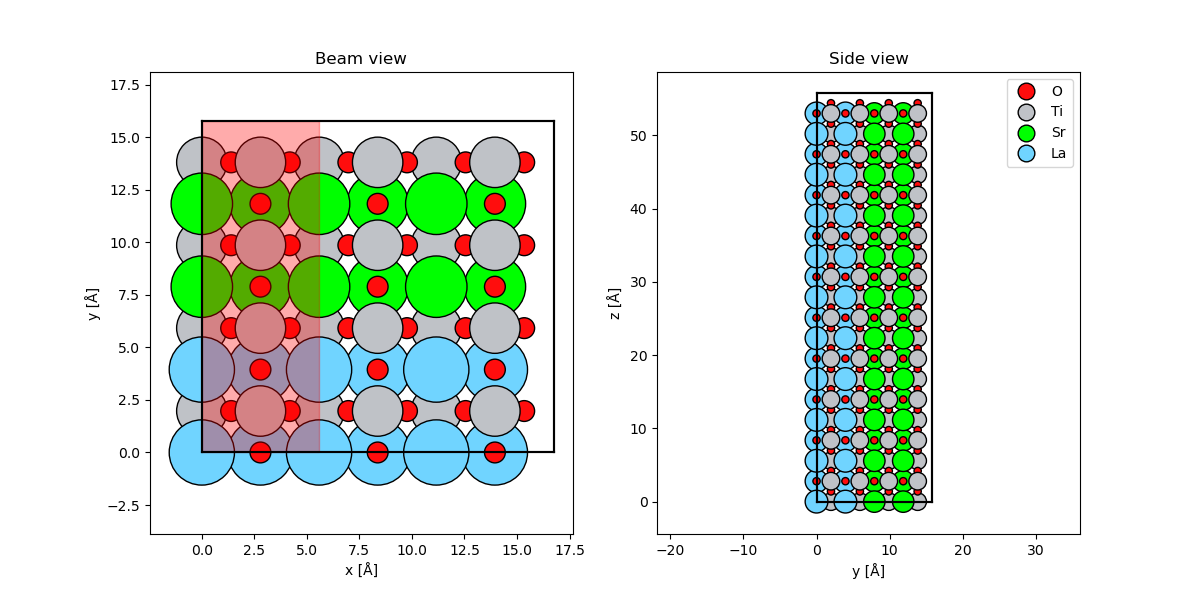

In [46]:
atoms = ase.io.read("data/sto_lto.cif")
potential = abtem.Potential(atoms, sampling=0.05, slice_thickness=2)

probe = abtem.Probe(energy=150e3, defocus=50, semiangle_cutoff=20, Cs=0.0)

probe.grid.match(potential)

scan = abtem.GridScan(
    start=(0, 0),
    end=(1 / 3, 1),
    sampling=probe.ctf.nyquist_sampling, # Equal to 0.36963 A
    fractional=True,
    potential=potential,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
abtem.show_atoms(atoms, ax=ax1, plane="xy", title="Beam view")
abtem.show_atoms(atoms, ax=ax2, plane="yz", title="Side view", legend=True);

scan.add_to_plot(ax1);

In [47]:
bright = abtem.AnnularDetector(inner=0, outer=20)
maadf = abtem.AnnularDetector(inner=40, outer=100)
haadf = abtem.AnnularDetector(inner=100, outer=180)

detectors = [bright, maadf, haadf]

In [8]:
scanned_measurements = probe.scan(
    scan=scan,
    detectors=detectors,
    potential=potential,
)

scanned_measurements.compute()

stacked_measurements = abtem.stack(scanned_measurements, ("BF", "MAADF", "HAADF"))

stacked_measurements.to_zarr("data/STO_LTO_STEM.zarr")

[########################################] | 100% Completed | 32.72 s
[########################################] | 100% Completed | 105.62 ms


[[None]]

In [9]:
stacked_measurements = abtem.from_zarr("data/STO_LTO_STEM.zarr").compute()

[########################################] | 100% Completed | 103.67 ms


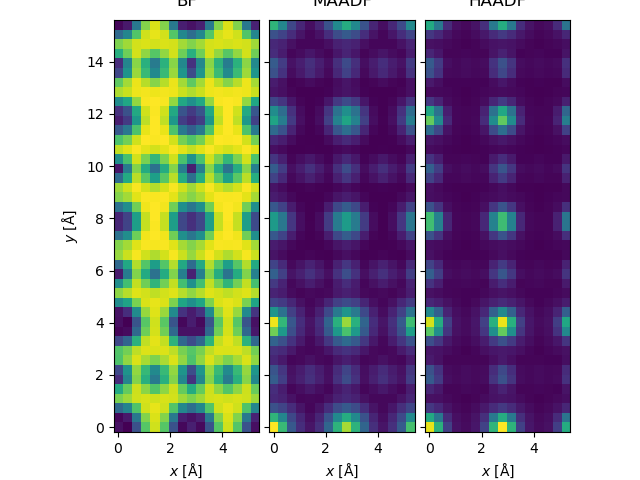

In [10]:
stacked_measurements.show(explode=True)

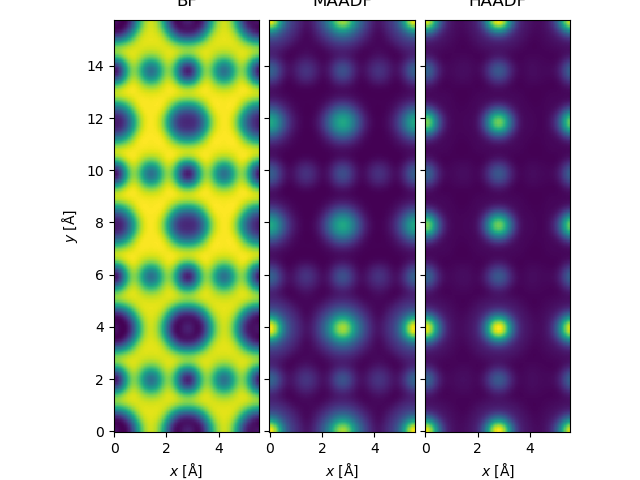

In [11]:
interpolated_measurements = stacked_measurements.interpolate(0.05)

interpolated_measurements.show(explode=True);

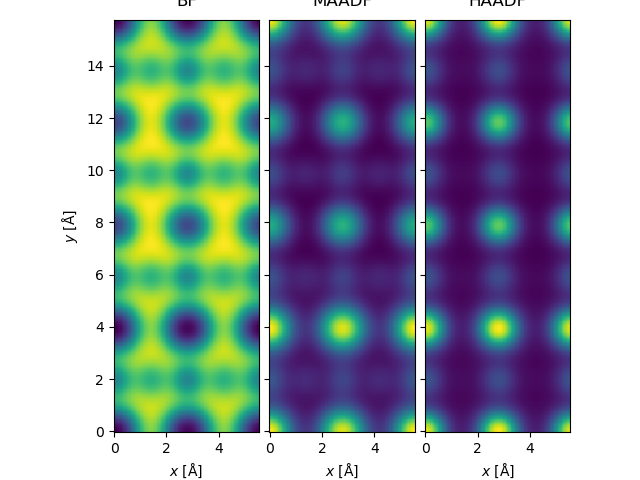

In [12]:
blurred_measurements = interpolated_measurements.gaussian_filter(0.35)

blurred_measurements.show(explode=True);

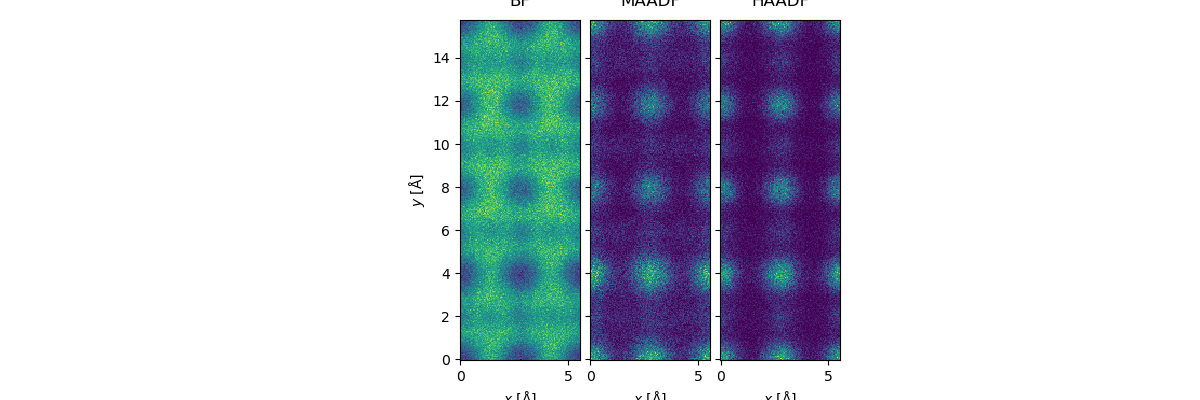

In [13]:
noisy_measurements = blurred_measurements.poisson_noise(dose_per_area=1e5, seed=100)

noisy_measurements.show(explode=True, figsize=(12, 4));

In [22]:
processed_measurements = abtem.stack([interpolated_measurements, blurred_measurements, noisy_measurements],
                               ("Interpolated", "Blurred", "Noised"))

In [23]:
processed_measurements.to_zarr("data/processed_STEM.zarr")

[########################################] | 100% Completed | 103.04 ms


[[None]]

In [16]:
stacked_measurements.to_zarr("data/unprocessed_STEM.zarr")

[########################################] | 100% Completed | 104.57 ms


[[None]]

#### Upscaling unprocessed image to make a single stack

In [17]:
from scipy.ndimage import zoom

scalex = interpolated_measurements[0].shape[0]/stacked_measurements[0].array.shape[0]
scaley = interpolated_measurements[1].shape[1]/stacked_measurements[0].array.shape[1]

zoomed0 = zoom(stacked_measurements[0].array, (scalex, scaley), order=0)
zoomed1 = zoom(stacked_measurements[1].array, (scalex, scaley), order=0)
zoomed2 = zoom(stacked_measurements[2].array, (scalex, scaley), order=0)

In [18]:
print(scalex)
print(scaley)

7.0
7.348837209302325


In [19]:
from abtem import Images

image0 = Images(zoomed0, sampling = interpolated_measurements[0].sampling)
image1 = Images(zoomed1, sampling = interpolated_measurements[1].sampling)
image2 = Images(zoomed2, sampling = interpolated_measurements[2].sampling)

zoomed_measurements = abtem.stack([image0, image1, image2], ("BF", "MAADF", "HAADF"))

In [24]:
all_measurements = abtem.stack([zoomed_measurements, interpolated_measurements, blurred_measurements, noisy_measurements],
                               ("Nyquist-sampled", "Interpolated", "Blurred", "Noised"))

all_measurements.to_zarr("data/processed_STEM.zarr")

[########################################] | 100% Completed | 102.54 ms


[[None]]